In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
import time
import math
import numpy as np
import mujoco as mj
import mujoco.viewer as viewer
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# ------------------ 1. Setup & Model Loading ------------------
MODEL_XML = "monstertruck.xml"  # File must exist

# Load Model
m = mj.MjModel.from_xml_path(MODEL_XML)
data = mj.MjData(m)

# Initial Reset to check connectivity
mj.mj_resetData(m, data)
mj.mj_forward(m, data)
data.ctrl[:] = 0.0

# ------------------ 2. Sensor & Joint Indices ------------------
# Find the free joint (chassis) to get state indices easily
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qpos_adr = m.jnt_qposadr[free_j]  # Start of qpos (x,y,z, w,x,y,z)

# Sensor IDs
gyro_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_gyro")
acc_id  = mj.mj_name2id(m, mj.mjtObj.mjOBJ_SENSOR, "imu_acc")

if gyro_id < 0 or acc_id < 0:
    raise RuntimeError("Sensors imu_gyro or imu_acc not found in XML!")

gyro_adr = m.sensor_adr[gyro_id]
acc_adr  = m.sensor_adr[acc_id]

# ------------------ 3. Helper Functions ------------------
def unwrap_angle(prev, prev_unwrapped, curr):
    """
    Incremental unwrap of an angle in [-pi, pi] to avoid visual jumps.
    """
    if prev is None:
        return curr, curr
    diff = curr - prev
    # handle wrap-around at ±pi
    if diff > math.pi: diff -= 2*math.pi
    elif diff < -math.pi: diff += 2*math.pi

    return curr, prev_unwrapped + diff

def quat_to_R_and_pitch(w, x, y, z):
    """
    Returns 3x3 Rotation Matrix and Euler pitch from quaternion (w,x,y,z).
    """
    n = math.sqrt(w*w + x*x + y*y + z*z)
    if n < 1e-9: n = 1.0
    w, x, y, z = w/n, x/n, y/n, z/n

    R = np.zeros((3,3))
    R[0,0]=1-2*(y*y+z*z); R[0,1]=2*(x*y-z*w); R[0,2]=2*(x*z+y*w)
    R[1,0]=2*(x*y+z*w); R[1,1]=1-2*(x*x+z*z); R[1,2]=2*(y*z-x*w)
    R[2,0]=2*(x*z-y*w); R[2,1]=2*(y*z+x*w); R[2,2]=1-2*(x*x+y*y)

    # Pitch
    sinp = 2*(w*y - z*x)
    if abs(sinp) >= 1: pitch = math.copysign(math.pi/2, sinp)
    else: pitch = math.asin(sinp)
    return R, pitch

print("✅ Setup complete. Model loaded and helpers defined.")

✅ Setup complete. Model loaded and helpers defined.


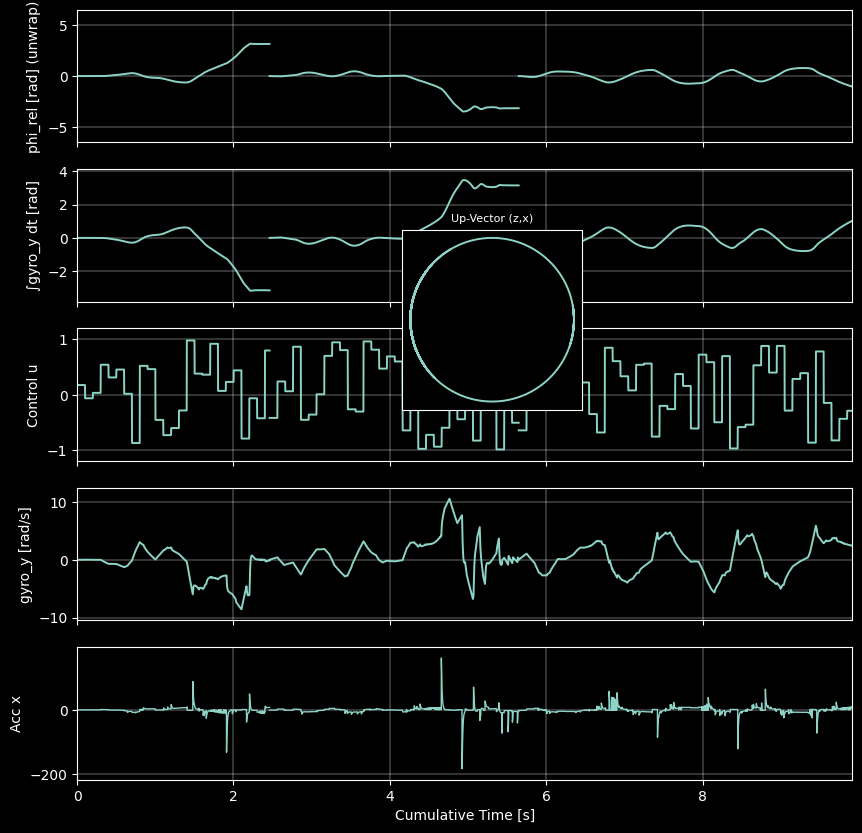

Collection Done. Plot Samples: 10003
✅ GP Dataset: Xtr (99, 3), Ytr (99, 2), CTRL_DT=0.1
phi_rel range: (-3.4574588563693136, 3.141904361513892)
rate range: (-8.540529134006526, 10.515260945049919)
u range: (-0.9892113697366749, 0.9810118949618558)
dphi range: (-0.8889944335545392, 0.7531000094793656)
drate range: (-6.787096000491118, 8.020494070903244)


In [3]:
# =============================================================================
# CELL 2: Data Collection (CONSISTENT STATE) for PLSSGP
#   X = [phi_rel, pitch_rate, u]
#   Y = [Δphi_rel, Δpitch_rate] over CTRL_DT
#
# phi_rel definition (matches your QLearning / MPPI):
#   theta = atan2(up_x, up_z) in [-pi, pi]
#   unwrap theta over time -> theta_unwrapped
#   phi_rel = theta_unwrapped - theta0
#   => upside-down start ≈ 0, upright ≈ ±pi  (±180 deg both upright)
#
# Reset/SUCCESS gate (optional): uses symmetric upright error:
#   err_upright = pi - abs(wrap_pi(phi_rel))
# =============================================================================

import time
import math
import numpy as np
import mujoco as mj
import mujoco.viewer as viewer
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# ------------------ Preconditions ------------------
for name in ["m", "data", "qpos_adr", "gyro_adr", "acc_adr", "quat_to_R_and_pitch", "unwrap_angle"]:
    assert name in globals(), f"Missing required global: {name}"

# ------------------ Config ------------------
CTRL_DT      = 0.1
DURATION     = 10.0         # total cumulative time (global)
U_MIN, U_MAX = -1.0, 1.0
RTF          = 1.0
REFRESH_HZ   = 5

MAX_GP_SAMPLES = None

MAX_ABS_D_PHI  = 6.5        # rad per CTRL_DT (phi can wrap/unwrap; allow > pi safely)
MAX_ABS_D_RATE = 80.0       # rad/s per CTRL_DT

# --- "completely upright + settled" gate (optional; for reset only) ---
UP_Z_THRESH      = 0.98
GYRO_THRESH      = 2.0       # rad/s on all axes
UPRIGHT_HOLD_S   = 0.25
PHI_UPRIGHT_TOL  = 0.20      # rad tolerance to the upright set {±pi}

# ------------------ Helpers ------------------
def wrap_pi(x: float) -> float:
    return (float(x) + math.pi) % (2.0 * math.pi) - math.pi

def err_to_upright(phi_rel: float) -> float:
    # 0 at ±pi, pi at 0
    return math.pi - abs(wrap_pi(phi_rel))

# Apply throttle ONLY to wheel actuators (avoid overwriting other actuators)
THROTTLE_IDS = []
for nm in ["front_left_motor", "front_right_motor", "rear_left_motor", "rear_right_motor"]:
    aid = mj.mj_name2id(m, mj.mjtObj.mjOBJ_ACTUATOR, nm)
    if aid != -1:
        THROTTLE_IDS.append(aid)
if not THROTTLE_IDS:
    THROTTLE_IDS = list(range(m.nu))
print("Throttle actuator ids:", THROTTLE_IDS, " (m.nu=", m.nu, ")")

def apply_throttle(u: float):
    if m.nu <= 0:
        return
    data.ctrl[:] = 0.0
    for aid in THROTTLE_IDS:
        data.ctrl[aid] = float(u)

# Camera follow body (if exists)
BODY_ID = mj.mj_name2id(m, mj.mjtObj.mjOBJ_BODY, "chassis")
if BODY_ID < 0:
    BODY_ID = 0

# ------------------ phi tracker (atan2 unwrap) ------------------
theta_prev_raw = None
theta_unwrapped = 0.0
theta0 = None

def reset_phi_tracker():
    global theta_prev_raw, theta_unwrapped, theta0
    theta_prev_raw = None
    theta_unwrapped = 0.0
    theta0 = None

def read_phi_rate_upz():
    global theta_prev_raw, theta_unwrapped, theta0

    qs = data.qpos[qpos_adr : qpos_adr + 7]
    Rm, euler_pitch = quat_to_R_and_pitch(qs[3], qs[4], qs[5], qs[6])

    up_x, up_z = float(Rm[0, 2]), float(Rm[2, 2])
    theta_raw = math.atan2(up_x, up_z)  # [-pi, pi]

    theta_prev_raw, theta_unwrapped = unwrap_angle(theta_prev_raw, theta_unwrapped, theta_raw)
    if theta0 is None:
        theta0 = theta_unwrapped

    phi_rel = float(theta_unwrapped - theta0)  # continuous, 0 at start

    gyro = data.sensordata[gyro_adr : gyro_adr + 3]
    rate = float(gyro[1])  # rad/s around body Y

    return phi_rel, rate, float(up_z), float(euler_pitch), np.array(gyro, dtype=np.float64)

# ------------------ Plotting Setup ------------------
plt.ioff()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

(line_phi,)   = ax1.plot([], [], lw=1.4)
ax1.set_ylabel("phi_rel [rad] (unwrap)")
ax1.set_ylim(-6.5, 6.5)

(line_flip,)  = ax2.plot([], [], lw=1.4)
ax2.set_ylabel("∫gyro_y dt [rad]")

(line_u,)     = ax3.plot([], [], lw=1.4)
ax3.set_ylabel("Control u")
ax3.set_ylim(U_MIN - 0.2, U_MAX + 0.2)

(line_rate,)  = ax4.plot([], [], lw=1.4)
ax4.set_ylabel("gyro_y [rad/s]")

(line_acc,)   = ax5.plot([], [], lw=1.0)
ax5.set_ylabel("Acc x")
ax5.set_xlabel("Cumulative Time [s]")

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.grid(True, linewidth=0.3)

# Inset: Up-Vector Visualization (z vs x)
ax_up = fig.add_axes([0.45, 0.48, 0.18, 0.18])
ax_up.plot(np.cos(np.linspace(-3.14, 3.14, 100)),
           np.sin(np.linspace(-3.14, 3.14, 100)), 'k--', alpha=0.3)
(line_upvec,) = ax_up.plot([], [], lw=1.4)
ax_up.set_aspect('equal'); ax_up.set_xticks([]); ax_up.set_yticks([])
ax_up.set_title("Up-Vector (z,x)", fontsize=8)

display(fig)

# ------------------ Simulation Loop ------------------
mj.mj_resetData(m, data)
mj.mj_forward(m, data)

# flipped-start pose (spawn control is HERE)
data.qpos[qpos_adr : qpos_adr + 3] = [0.0, 0.0, 0.15]
data.qpos[qpos_adr + 3 : qpos_adr + 7] = [0.0, 1.0, 0.0, 0.0]
mj.mj_forward(m, data)

reset_phi_tracker()
apply_throttle(0.0)

sim_dt = float(m.opt.timestep)
upright_need_steps = int(max(1, round(UPRIGHT_HOLD_S / sim_dt)))
upright_counter = 0

# Logs
t_log, phi_log, flip_int_log, u_log, rate_log, acc_log, vz_log, vx_log = [], [], [], [], [], [], [], []

cumulative_offset = 0.0
next_cmd = 0.0
u = 0.0

flip_integral = 0.0

# ------------------ GP dataset buffers ------------------
X_list, Y_list = [], []

hold_active = False
hold_phi0  = 0.0
hold_rate0 = 0.0
hold_u     = 0.0

t0_wall = time.perf_counter()
last_refresh_wall = t0_wall

def autoscale_y(ax, data_list, margin=0.1):
    valid = [x for x in data_list if not np.isnan(x)]
    if not valid:
        return
    ymin, ymax = min(valid), max(valid)
    r = ymax - ymin
    if r < 1e-6: r = 1.0
    ax.set_ylim(ymin - r*margin, ymax + r*margin)

def close_hold_interval_if_active():
    nonlocal_hold = globals()  # just to avoid accidental closure capture in notebooks
    if not nonlocal_hold.get("hold_active", False):
        return

    phi_end, rate_end, _, _, _ = read_phi_rate_upz()
    dphi  = float(phi_end - nonlocal_hold["hold_phi0"])
    drate = float(rate_end - nonlocal_hold["hold_rate0"])

    if (abs(dphi) <= MAX_ABS_D_PHI) and (abs(drate) <= MAX_ABS_D_RATE):
        X_list.append([nonlocal_hold["hold_phi0"], nonlocal_hold["hold_rate0"], nonlocal_hold["hold_u"]])
        Y_list.append([dphi, drate])

print("🚀 Starting Data Collection...")

with viewer.launch_passive(m, data) as v:
    v.cam.distance = 4.5

    while (cumulative_offset + data.time) < DURATION and (MAX_GP_SAMPLES is None or len(X_list) < MAX_GP_SAMPLES):

        # camera follow
        try:
            v.cam.lookat[:] = data.xpos[BODY_ID]
        except Exception:
            pass

        # 1) Control: new u every CTRL_DT
        if data.time >= next_cmd:
            close_hold_interval_if_active()

            u = float(np.random.uniform(U_MIN, U_MAX))
            apply_throttle(u)
            next_cmd += CTRL_DT

            phi0, rate0, _, _, _ = read_phi_rate_upz()
            hold_active = True
            hold_phi0   = float(phi0)
            hold_rate0  = float(rate0)
            hold_u      = float(u)

        # 2) Physics step
        mj.mj_step(m, data)

        # 3) State extraction
        phi_rel, rate, up_z, euler_pitch, gyro_vec = read_phi_rate_upz()
        acc = data.sensordata[acc_adr : acc_adr + 3]

        flip_integral += float(gyro_vec[1]) * sim_dt

        # 4) Logging
        t_global = cumulative_offset + data.time
        t_log.append(float(t_global))
        phi_log.append(float(phi_rel))
        flip_int_log.append(float(flip_integral))
        u_log.append(float(u))
        rate_log.append(float(rate))
        acc_log.append(float(acc[0]))
        vz_log.append(float(up_z))
        # for inset: (z,x)
        qs = data.qpos[qpos_adr : qpos_adr + 7]
        Rm, _ = quat_to_R_and_pitch(qs[3], qs[4], qs[5], qs[6])
        vx_log.append(float(Rm[0,2]))  # up_x

        # 5) SUCCESS/RESET gate (optional; for data segmentation only)
        gyro_abs_ok = (abs(float(gyro_vec[0])) < GYRO_THRESH and
                       abs(float(gyro_vec[1])) < GYRO_THRESH and
                       abs(float(gyro_vec[2])) < GYRO_THRESH)

        upright_phi_ok = (err_to_upright(phi_rel) < PHI_UPRIGHT_TOL)
        upright_now = (up_z > UP_Z_THRESH) and upright_phi_ok and gyro_abs_ok

        upright_counter = upright_counter + 1 if upright_now else 0

        if upright_counter >= upright_need_steps:
            print(f"✅ Upright+settled for {UPRIGHT_HOLD_S:.2f}s at Global T={t_global:.2f}s! Resetting...")

            cumulative_offset += data.time
            for l in [t_log, phi_log, flip_int_log, u_log, rate_log, acc_log, vz_log, vx_log]:
                l.append(np.nan)

            hold_active = False

            mj.mj_resetData(m, data)
            # spawn control is HERE
            data.qpos[qpos_adr : qpos_adr + 3] = [0.0, 0.0, 0.15]
            data.qpos[qpos_adr + 3 : qpos_adr + 7] = [0.0, 1.0, 0.0, 0.0]
            mj.mj_forward(m, data)

            reset_phi_tracker()
            next_cmd = 0.0
            flip_integral = 0.0
            upright_counter = 0

            u = 0.0
            apply_throttle(u)

        # 6) Plot refresh
        now = time.perf_counter()
        if now - last_refresh_wall >= (1.0 / REFRESH_HZ):
            line_phi.set_data(t_log, phi_log)
            line_flip.set_data(t_log, flip_int_log)
            line_u.set_data(t_log, u_log)
            line_rate.set_data(t_log, rate_log)
            line_acc.set_data(t_log, acc_log)
            line_upvec.set_data(vz_log, vx_log)

            ax1.set_xlim(0, max(5.0, float(t_global)))
            autoscale_y(ax2, flip_int_log)
            autoscale_y(ax4, rate_log)
            autoscale_y(ax5, acc_log)

            clear_output(wait=True)
            display(fig)
            last_refresh_wall = now

        # 7) pacing
        sim_time = cumulative_offset + data.time
        wall_time = time.perf_counter() - t0_wall
        if sim_time > wall_time * RTF:
            time.sleep(0.002)

        v.sync()

# close last interval
if hold_active and (MAX_GP_SAMPLES is None or len(X_list) < MAX_GP_SAMPLES):
    close_hold_interval_if_active()

Xtr = np.asarray(X_list, dtype=np.float64)  # (N,3) [phi_rel, rate, u]
Ytr = np.asarray(Y_list, dtype=np.float64)  # (N,2) [dphi, drate]

print(f"Collection Done. Plot Samples: {len(t_log)}")
print(f"✅ GP Dataset: Xtr {Xtr.shape}, Ytr {Ytr.shape}, CTRL_DT={CTRL_DT}")
if Xtr.shape[0] > 0:
    print("phi_rel range:", (float(np.min(Xtr[:,0])), float(np.max(Xtr[:,0]))))
    print("rate range:",    (float(np.min(Xtr[:,1])), float(np.max(Xtr[:,1]))))
    print("u range:",       (float(np.min(Xtr[:,2])), float(np.max(Xtr[:,2]))))
    print("dphi range:",    (float(np.min(Ytr[:,0])), float(np.max(Ytr[:,0]))))
    print("drate range:",   (float(np.min(Ytr[:,1])), float(np.max(Ytr[:,1]))))


In [4]:
# ===========================
# Cell 3 — OSGPR-VFE core (Streaming Sparse GP) + training + summaries + anchors
# MONSTERTRUCK version (minimal state):
#   X = [pitch, pitch_rate, u]   (N,3)
#   Y = [Δpitch, Δpitch_rate]    (N,2)  -> we train two single-output models
#
# ✅ FOLLOWS your original CartPole Cell 3 pipeline:
#   - OSGPR_VFE (single-output) exactly in your style (common_terms, cache)
#   - train_osgpr(), prior_summary(), extract_summary_from_model()
#   - greedy_dopt_anchors_from_K()
#   - rebuild_osgpr_from_old_summary()
#
# ✅ Adds: adaptive inducing init M0 (won't break when N < M_TARGET)
# ✅ Adds: k-center init for Z0 (better than random)
# ===========================

import time
import copy
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.inducing_variables import InducingPoints
from gpflow.models import GPModel, InternalDataTrainingLossMixin
from gpflow import covariances

# ---- numerics ----
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")

print("TF built with CUDA:", tf.test.is_built_with_cuda())
try:
    print("GPUs visible:", tf.config.list_physical_devices("GPU"))
except Exception as e:
    print("GPU query failed:", e)

DTYPE = gpflow.default_float()

# ---------------------------
# helpers (same as your code)
# ---------------------------
def sym_jitter(A, jitter=1e-6):
    """Make symmetric + add jitter (numpy)."""
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    A = A + float(jitter) * np.eye(A.shape[0], dtype=np.float64)
    return A

def finite_mask(*arrs):
    """Row-wise finite mask across arrays."""
    m = None
    for a in arrs:
        a = np.asarray(a)
        mm = np.isfinite(a).all(axis=1) if a.ndim == 2 else np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m

def clone_kernel(kernel):
    """
    Clone a GPflow kernel (to avoid variable-sharing across models).
    """
    try:
        from gpflow.utilities import deepcopy as gf_deepcopy
        return gf_deepcopy(kernel)
    except Exception:
        return copy.deepcopy(kernel)

# ------------------------------------------------------------
# MonsterTruck feature map (identity)
# ------------------------------------------------------------
def X_is_features(X):
    """
    X already equals features for this environment:
      X = [pitch, pitch_rate, u]
    """
    X = np.asarray(X, dtype=np.float64)
    assert X.ndim == 2 and X.shape[1] == 3, "Expected X shape (N,3) = [pitch, pitch_rate, u]"
    return X

# ============================================================
# OSGPR-VFE model — regression-only, single-output (YOUR IMPLEMENTATION)
# ============================================================
class OSGPR_VFE(GPModel, InternalDataTrainingLossMixin):
    """
    Online Sparse Variational GP Regression (VFE), SINGLE-OUTPUT.

    Provide:
      - current batch data (X, Y)
      - old summary q_old(u)=N(mu_old, Su_old) at Z_old
      - Kaa_old = K(Z_old,Z_old) from old step
      - new inducing Z (usually Z_GLOBAL; you MAY refresh Z over time, but size should be capped)

    Includes:
      - predict_f (correct but slower)
      - build_predict_cache + predict_f_cached (FAST diag predictions)
    """
    def __init__(self, data, kernel, mu_old, Su_old, Kaa_old, Z_old, Z, mean_function=None):
        X, Y = gpflow.models.util.data_input_to_tensor(data)
        self.X, self.Y = X, Y

        likelihood = gpflow.likelihoods.Gaussian()
        num_latent_gps = GPModel.calc_num_latent_gps_from_data(data, kernel, likelihood)
        super().__init__(kernel, likelihood, mean_function, num_latent_gps)

        Z = np.asarray(Z, dtype=np.float64)
        assert Z.ndim == 2, "Z must be (M, D)"
        self.inducing_variable = InducingPoints(Z)
        gpflow.set_trainable(self.inducing_variable, False)

        mu_old  = np.asarray(mu_old, dtype=np.float64).reshape(-1, 1)
        Su_old  = sym_jitter(Su_old,  1e-6)
        Kaa_old = sym_jitter(Kaa_old, 1e-6)
        Z_old   = np.asarray(Z_old, dtype=np.float64)

        self.mu_old  = tf.Variable(mu_old,  trainable=False, dtype=DTYPE)
        self.Su_old  = tf.Variable(Su_old,  trainable=False, dtype=DTYPE)
        self.Kaa_old = tf.Variable(Kaa_old, trainable=False, dtype=DTYPE)
        self.Z_old   = tf.Variable(Z_old,   trainable=False, dtype=DTYPE)

        if self.mean_function is None:
            self.mean_function = gpflow.mean_functions.Zero()

        # cache for fast predict
        self._cache_ready = False
        self._cache_Lb = None
        self._cache_LD = None
        self._cache_rhs = None

    def _common_terms(self):
        """
        Build common matrices used by both ELBO and prediction.
        """
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance

        Saa = self.Su_old  # [Ma,Ma]
        ma  = self.mu_old  # [Ma,1]

        Kbf = covariances.Kuf(self.inducing_variable, self.kernel, self.X)           # [Mb, N]
        Kbb = covariances.Kuu(self.inducing_variable, self.kernel, jitter=jitter)   # [Mb, Mb]
        Kba = covariances.Kuf(self.inducing_variable, self.kernel, self.Z_old)      # [Mb, Ma]

        Kaa_cur = gpflow.utilities.add_noise_cov(self.kernel(self.Z_old), jitter)   # [Ma,Ma]
        Kaa     = gpflow.utilities.add_noise_cov(self.Kaa_old, jitter)              # [Ma,Ma]

        err = self.Y - self.mean_function(self.X)  # [N,1]

        # c = Kbf*(Y/sigma2) + Kba*(Saa^{-1} ma)
        Sainv_ma = tf.linalg.solve(Saa, ma)                                # [Ma,1]
        c = tf.matmul(Kbf, self.Y / sigma2) + tf.matmul(Kba, Sainv_ma)     # [Mb,1]

        # Cholesky(Kbb)
        Lb = tf.linalg.cholesky(Kbb)                                       # [Mb,Mb]
        Lbinv_c   = tf.linalg.triangular_solve(Lb, c,   lower=True)        # [Mb,1]
        Lbinv_Kba = tf.linalg.triangular_solve(Lb, Kba, lower=True)        # [Mb,Ma]
        Lbinv_Kbf = tf.linalg.triangular_solve(Lb, Kbf, lower=True) / tf.sqrt(sigma2)  # [Mb,N]

        d1 = tf.matmul(Lbinv_Kbf, Lbinv_Kbf, transpose_b=True)             # [Mb,Mb]

        # T = (Lb^{-1}Kba)^T  => [Ma,Mb]
        T = tf.linalg.matrix_transpose(Lbinv_Kba)

        # d2
        LSa = tf.linalg.cholesky(Saa)
        LSainv_T = tf.linalg.triangular_solve(LSa, T, lower=True)
        d2 = tf.matmul(LSainv_T, LSainv_T, transpose_a=True)               # [Mb,Mb]

        # d3
        La = tf.linalg.cholesky(Kaa)
        Lainv_T = tf.linalg.triangular_solve(La, T, lower=True)
        d3 = tf.matmul(Lainv_T, Lainv_T, transpose_a=True)                 # [Mb,Mb]

        Mb = self.inducing_variable.num_inducing
        D = tf.eye(Mb, dtype=DTYPE) + d1 + d2 - d3
        D = gpflow.utilities.add_noise_cov(D, jitter)
        LD = tf.linalg.cholesky(D)

        rhs = tf.linalg.triangular_solve(LD, Lbinv_c, lower=True)          # [Mb,1]

        Qff_diag = tf.reduce_sum(tf.square(Lbinv_Kbf), axis=0)             # [N]

        tf.debugging.assert_all_finite(Lb,  "Lb has NaN/Inf")
        tf.debugging.assert_all_finite(LD,  "LD has NaN/Inf")
        tf.debugging.assert_all_finite(rhs, "rhs has NaN/Inf")

        return (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD, Lbinv_Kba, rhs, err, Qff_diag)

    def maximum_log_likelihood_objective(self):
        sigma2 = self.likelihood.variance
        N = tf.cast(tf.shape(self.X)[0], DTYPE)

        Saa = self.Su_old
        ma  = self.mu_old
        Kfdiag = self.kernel(self.X, full_cov=False)

        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, rhs, err, Qff_diag) = self._common_terms()

        LSa = tf.linalg.cholesky(Saa)
        Lainv_ma = tf.linalg.triangular_solve(LSa, ma, lower=True)

        bound = -0.5 * N * np.log(2.0 * np.pi)
        bound += -0.5 * tf.reduce_sum(tf.square(err)) / sigma2
        bound += -0.5 * tf.reduce_sum(tf.square(Lainv_ma))
        bound +=  0.5 * tf.reduce_sum(tf.square(rhs))

        bound += -0.5 * N * tf.math.log(sigma2)
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LD)))

        bound += -0.5 * tf.reduce_sum(Kfdiag) / sigma2
        bound +=  0.5 * tf.reduce_sum(Qff_diag)

        bound += tf.reduce_sum(tf.math.log(tf.linalg.diag_part(La)))
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LSa)))

        # correction term involving Kaa_cur - Qaa
        Kaadiff = Kaa_cur - tf.matmul(Lbinv_Kba, Lbinv_Kba, transpose_a=True)
        Sainv_Kaadiff = tf.linalg.solve(Saa, Kaadiff)
        Kainv_Kaadiff = tf.linalg.solve(Kaa, Kaadiff)

        bound += -0.5 * tf.reduce_sum(
            tf.linalg.diag_part(Sainv_Kaadiff) - tf.linalg.diag_part(Kainv_Kaadiff)
        )
        return bound

    def predict_f(self, Xnew, full_cov=False):
        jitter = gpflow.utilities.to_default_float(1e-6)

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [Mb, Nnew]
        (_, _, _, _, _, _, Lb, _, LD, _, rhs, _, _) = self._common_terms()

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)  # [Nnew,1]

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=DTYPE)
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

    def build_predict_cache(self):
        """Build cached matrices for fast predict_f_cached(). Call after training / after each update."""
        (_, _, _, _, _, _, Lb, _, LD, _, rhs, _, _) = self._common_terms()
        self._cache_Lb = Lb
        self._cache_LD = LD
        self._cache_rhs = rhs
        self._cache_ready = True

    def predict_f_cached(self, Xnew, full_cov=False):
        """Fast diag prediction using cached Lb, LD, rhs."""
        if not self._cache_ready:
            return self.predict_f(Xnew, full_cov=full_cov)

        jitter = gpflow.utilities.to_default_float(1e-6)
        Lb  = self._cache_Lb
        LD  = self._cache_LD
        rhs = self._cache_rhs

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [Mb,Nnew]
        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=DTYPE)
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

# ----------------------------
# training helper (same as your code)
# ----------------------------
def train_osgpr(model, iters=250, lr=0.02, clip_norm=10.0):
    """Adam optimize the negative ELBO."""
    opt = tf.keras.optimizers.Adam(lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.maximum_log_likelihood_objective()
        grads = tape.gradient(loss, model.trainable_variables)
        if clip_norm is not None:
            grads = [tf.clip_by_norm(g, clip_norm) if g is not None else None for g in grads]
        opt.apply_gradients([(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None])
        return loss

    t0 = time.time()
    last = None
    for _ in range(int(iters)):
        last = step()
    return float(time.time() - t0), float(last.numpy())

# ----------------------------
# summaries (same as your code)
# ----------------------------
def prior_summary(kernel, Z):
    """
    Prior summary at inducing Z for the first model:
      mu0 = 0
      Su0 = Kzz
      Kaa0 = Kzz
    """
    Z = np.asarray(Z, dtype=np.float64)
    Kzz = kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, 1e-6)
    mu0 = np.zeros((Z.shape[0], 1), dtype=np.float64)
    return mu0, Kzz, Kzz, Z

def extract_summary_from_model(model):
    """
    Extract q(u)=N(mu,Su) at model's current inducing Z plus Kaa=K(Z,Z).
    """
    Z = model.inducing_variable.Z.numpy().astype(np.float64)

    mu_tf, Sig_tf = model.predict_f(Z, full_cov=True)
    mu = mu_tf.numpy().reshape(-1, 1)

    Su = Sig_tf.numpy()
    if Su.ndim == 3:
        Su = Su[0]
    Su = sym_jitter(Su, 1e-6)

    Kaa = model.kernel.K(Z).numpy()
    Kaa = sym_jitter(Kaa, 1e-6)
    return mu, Su, Kaa, Z

# ============================================================
# Anchors: greedy D-opt (your function)
# ============================================================
def greedy_dopt_anchors_from_K(Kzz, m_anchors=24, lam=1e-6):
    K = np.asarray(Kzz, dtype=np.float64)
    M = K.shape[0]
    assert K.shape == (M, M)
    K = sym_jitter(K, lam)

    chosen = []
    diag = np.clip(np.diag(K).copy(), 1e-12, None)
    remaining = np.ones(M, dtype=bool)
    L = None

    for k in range(min(int(m_anchors), M)):
        if k == 0:
            i = int(np.argmax(diag))
            chosen.append(i)
            remaining[i] = False
            L = np.array([[np.sqrt(diag[i])]], dtype=np.float64)
            continue

        S = np.array(chosen, dtype=np.int64)
        Ks_all = K[np.ix_(S, np.arange(M))]     # (k,M)

        v = np.linalg.solve(L, Ks_all)          # (k,M)
        vn2 = np.sum(v * v, axis=0)             # (M,)
        s2 = diag - vn2
        s2 = np.where(remaining, s2, -np.inf)

        i = int(np.argmax(s2))
        if not np.isfinite(s2[i]) or s2[i] <= 1e-12:
            cand = np.where(remaining)[0]
            if len(cand) == 0:
                break
            i = int(cand[np.argmax(diag[cand])])
            s2_i = max(diag[i], 1e-12)
        else:
            s2_i = float(s2[i])

        chosen.append(i)
        remaining[i] = False

        kvec = K[np.ix_(S, [i])].reshape(-1, 1)  # (k,1)
        w = np.linalg.solve(L, kvec)             # (k,1)
        alpha = np.sqrt(max(s2_i, 1e-12))

        L_new = np.zeros((k + 1, k + 1), dtype=np.float64)
        L_new[:k, :k] = L
        L_new[k, :k] = w.reshape(-1)
        L_new[k, k] = alpha
        L = L_new

    return np.array(chosen, dtype=np.int64)

# ============================================================
# Online update builder (your function, with tiny convenience)
# ============================================================
def rebuild_osgpr_from_old_summary(
    model_old,
    X_new,
    Y_new,
    Z_new=None,
    iters=120,
    lr=0.02,
    noise=1e-4,
    freeze_kernel=True,
    clip_norm=10.0,
):
    """
    Build a NEW OSGPR_VFE model using:
      - old posterior summary extracted from model_old at its inducing Z_old
      - new executed batch (X_new, Y_new)
      - inducing set Z_new (defaults to model_old.Z; you may pass a refreshed Z here)

    Returns:
      model_new, train_time_sec, last_neg_obj
    """
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)

    if Z_new is None:
        Z_use = Z_old
    else:
        Z_use = np.asarray(Z_new, dtype=np.float64)

    k_new = clone_kernel(model_old.kernel)

    X_new = np.asarray(X_new, dtype=np.float64)
    Y_new = np.asarray(Y_new, dtype=np.float64).reshape(-1, 1)

    m = OSGPR_VFE(
        data=(X_new, Y_new),
        kernel=k_new,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_use,
    )
    m.likelihood.variance.assign(float(noise))

    if freeze_kernel:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass

    t_sec, neg = train_osgpr(m, iters=iters, lr=lr, clip_norm=clip_norm)
    m.build_predict_cache()
    return m, float(t_sec), float(neg)

# ============================================================
# NEW: adaptive inducing init + k-center (safe when N < M_TARGET)
# ============================================================
def kcenter_select(X, M, seed=0):
    X = np.asarray(X, dtype=np.float64)
    N = X.shape[0]
    if M >= N:
        return np.arange(N, dtype=np.int64)

    rng = np.random.default_rng(seed)
    first = int(rng.integers(0, N))
    selected = [first]
    d2 = np.sum((X - X[first])**2, axis=1)

    for _ in range(1, M):
        i = int(np.argmax(d2))
        selected.append(i)
        d2 = np.minimum(d2, np.sum((X - X[i])**2, axis=1))

    return np.array(selected, dtype=np.int64)

# ============================================================
# INITIAL TRAINING (two models) — aligned with your pipeline
# ============================================================
assert "Xtr" in globals() and "Ytr" in globals(), "Run Cell 2 first to create Xtr, Ytr"
Xtr = np.asarray(Xtr, dtype=np.float64)
Ytr = np.asarray(Ytr, dtype=np.float64)

# filter finite rows (Cell 2 inserts NaNs in plot logs, but Xtr/Ytr should already be clean;
# this is extra safety)
mfin = finite_mask(Xtr, Ytr)
Xtr = Xtr[mfin]
Ytr = Ytr[mfin]

Xtr = X_is_features(Xtr)
assert Ytr.ndim == 2 and Ytr.shape[1] == 2, "Ytr must be (N,2) = [Δpitch, Δpitch_rate]"

N = Xtr.shape[0]
Din = Xtr.shape[1]
print("Init data:", Xtr.shape, Ytr.shape)

# ---- adaptive inducing ----
M_TARGET = 512
M_MIN    = 128
RHO      = 0.5

M0 = int(min(M_TARGET, max(M_MIN, np.floor(RHO * N))))
M0 = min(M0, N)
if M0 < 8:
    raise RuntimeError(f"Too few samples to start (N={N}). Collect more data first.")

idxZ = kcenter_select(Xtr, M0, seed=0)
Z0 = Xtr[idxZ].copy()
print(f"Adaptive inducing init: M0={M0} (target={M_TARGET}, min={M_MIN}, rho={RHO})  Z0={Z0.shape}")

# ---- kernel (same for both outputs) ----
# keep it simple & stable at first; you can unfreeze later
kernel0 = gpflow.kernels.SquaredExponential(lengthscales=np.ones(Din), variance=1.0) + gpflow.kernels.Linear(variance=0.1)

# ---- build initial summaries from the PRIOR (exactly your pipeline) ----
mu0, Su0, Kaa0, Zold0 = prior_summary(kernel0, Z0)

# ---- build two initial models ----
noise0 = 1e-3
ITERS0 = 700
LR0    = 0.02

# Δpitch
m_dpitch = OSGPR_VFE(
    data=(Xtr, Ytr[:, 0:1]),
    kernel=clone_kernel(kernel0),
    mu_old=mu0, Su_old=Su0, Kaa_old=Kaa0, Z_old=Zold0,
    Z=Z0,
)
m_dpitch.likelihood.variance.assign(float(noise0))

# Δpitch_rate
m_drate = OSGPR_VFE(
    data=(Xtr, Ytr[:, 1:2]),
    kernel=clone_kernel(kernel0),
    mu_old=mu0, Su_old=Su0, Kaa_old=Kaa0, Z_old=Zold0,
    Z=Z0,
)
m_drate.likelihood.variance.assign(float(noise0))

# Optionally freeze kernel initially (often helps stability)
try:
    m_dpitch.kernel.variance.trainable = False
    m_dpitch.kernel.kernels[0].lengthscales.trainable = False  # if Sum kernel layout differs, ignore
except Exception:
    pass
try:
    m_drate.kernel.variance.trainable = False
    m_drate.kernel.kernels[0].lengthscales.trainable = False
except Exception:
    pass

print("Training initial GLOBAL models...")
t_dp, neg_dp = train_osgpr(m_dpitch, iters=ITERS0, lr=LR0, clip_norm=10.0)
m_dpitch.build_predict_cache()

t_dr, neg_dr = train_osgpr(m_drate,  iters=ITERS0, lr=LR0, clip_norm=10.0)
m_drate.build_predict_cache()

print("✅ Initial training done.")
print("  Δpitch: time(s)=", round(t_dp, 3), "neg_obj=", round(neg_dp, 6))
print("  Δrate : time(s)=", round(t_dr, 3), "neg_obj=", round(neg_dr, 6))

# ---- anchors selected from CURRENT inducing Z (your rule) ----
Kzz = m_dpitch.kernel.K(Z0).numpy()
M_ANCHORS = int(min(24, max(8, M0 // 8)))
anchor_idx = greedy_dopt_anchors_from_K(Kzz, m_anchors=M_ANCHORS, lam=1e-6)
print("Anchors:", anchor_idx.shape, "M_ANCHORS=", M_ANCHORS, "unique=", len(np.unique(anchor_idx)))

PLSSGP = {
    "dt_ctrl": float(CTRL_DT),
    "feat_names": ["pitch", "pitch_rate", "u"],
    "out_names":  ["d_pitch", "d_rate"],
    "M_TARGET": int(M_TARGET),
    "M_MIN": int(M_MIN),
    "RHO": float(RHO),

    "Z_GLOBAL": Z0,               # current global inducing set
    "anchor_idx": anchor_idx,     # anchors on current Z

    "models": {
        "d_pitch": m_dpitch,
        "d_rate":  m_drate,
    }
}

print("✅ OSGPR core ready (MonsterTruck)")


2026-02-04 18:37:52.219506: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-04 18:37:52.244640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-04 18:37:53.038711: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/tongshuwu/PycharmProjects/MonsterTruck/.venv/lib/python3.12/site-packages/gpflow/vers

TF built with CUDA: True
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Init data: (99, 3) (99, 2)
Adaptive inducing init: M0=99 (target=512, min=128, rho=0.5)  Z0=(99, 3)
Training initial GLOBAL models...


I0000 00:00:1770248277.440853   49077 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x24cb76c0


✅ Initial training done.
  Δpitch: time(s)= 9.819 neg_obj= -123.766462
  Δrate : time(s)= 6.971 neg_obj= 149.814772
Anchors: (12,) M_ANCHORS= 12 unique= 12
✅ OSGPR core ready (MonsterTruck)


In [5]:
# =============================================================================
# CELL 4 — GLOBAL GP Eval + Plotly Surfaces (PyCharm/Linux reliable)
#   - ALWAYS writes HTML -> opens via xdg-open
# =============================================================================

import os
import time
import numpy as np
import tensorflow as tf
import gpflow
import plotly.graph_objects as go
import plotly.io as pio

# ----------------------------
# 0) Reliable "show" in PyCharm/Linux: write HTML + xdg-open
# ----------------------------
PLOT_DIR = "./_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

def show_plotly(fig, name="plot"):
    ts = time.strftime("%Y%m%d_%H%M%S")
    path = os.path.join(PLOT_DIR, f"{ts}_{name}.html")
    pio.write_html(fig, file=path, auto_open=False, include_plotlyjs="cdn")
    abspath = os.path.abspath(path)
    print(f"[plotly] wrote: {abspath}")
    # open in default browser
    os.system(f'xdg-open "{abspath}" >/dev/null 2>&1 &')

# ----------------------------
# 1) Grab models + data
# ----------------------------
assert "PLSSGP" in globals(), "Run Cell 3 first (creates PLSSGP)."
m_dpitch = PLSSGP["models"]["d_pitch"]
m_drate  = PLSSGP["models"]["d_rate"]

X_all = np.asarray(Xtr, dtype=np.float64)
Y_all = np.asarray(Ytr, dtype=np.float64)

assert X_all.ndim == 2 and X_all.shape[1] == 3, "Xtr must be (N,3)=[pitch,pitch_rate,u]"
assert Y_all.ndim == 2 and Y_all.shape[1] == 2, "Ytr must be (N,2)=[Δpitch,Δpitch_rate]"

# ----------------------------
# 2) Train/test split
# ----------------------------
def make_split(X, Y, test_frac=0.2, seed=0):
    rng = np.random.default_rng(seed)
    N = X.shape[0]
    idx = rng.permutation(N)
    n_te = int(max(1, round(test_frac * N)))
    te = idx[:n_te]
    tr = idx[n_te:]
    return X[tr], Y[tr], X[te], Y[te]

Xtr_eval, Ytr_eval, Xte, Yte = make_split(X_all, Y_all, test_frac=0.2, seed=0)
Ydp_te = Yte[:, 0:1]
Ydr_te = Yte[:, 1:2]

# ----------------------------
# 3) Fast predict helper (uses your cache if present)
# ----------------------------
def gp_predict_mu_std_fast(model, X):
    X = np.asarray(X, dtype=np.float64)
    Xtf = tf.convert_to_tensor(X, dtype=gpflow.default_float())

    if hasattr(model, "predict_f_cached") and getattr(model, "_cache_ready", False):
        mu_tf, var_tf = model.predict_f_cached(Xtf, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(Xtf, full_cov=False)

    mu = np.asarray(mu_tf.numpy()).reshape(-1)
    var = np.asarray(var_tf.numpy()).reshape(-1)
    var = np.maximum(var, 1e-12)
    std = np.sqrt(var)
    return mu, std

# ----------------------------
# 4) RMSE report
# ----------------------------
def rmse_np(yhat, y):
    yhat = np.asarray(yhat).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.sqrt(np.mean((yhat - y) ** 2)))

def print_global_rmse(tag=""):
    mu_dp, _ = gp_predict_mu_std_fast(m_dpitch, Xte)
    mu_dr, _ = gp_predict_mu_std_fast(m_drate,  Xte)
    print("\n=== Test RMSE (global models) ===" + (f"  [{tag}]" if tag else ""))
    print(f"Δpitch       RMSE: {rmse_np(mu_dp, Ydp_te):.6f}")
    print(f"Δpitch_rate  RMSE: {rmse_np(mu_dr, Ydr_te):.6f}")

# ----------------------------
# 5) Plotly slice (mean ±2σ) vs pitch for u=+1/-1
# ----------------------------
def plot_slice_pitch_two_actions_plotly(
    model,
    name="slice",
    title="Slice: mean ±2σ vs pitch (u=+1/-1)",
    y_label="Δpitch",
    pitch_rate_fixed=0.0,
    pitch_min=-np.pi, pitch_max=np.pi,
    n_grid=500,
    u_list=(+1.0, -1.0),
    show_inducing=True,
):
    pitch_grid = np.linspace(pitch_min, pitch_max, n_grid)
    fig = go.Figure()

    for u in u_list:
        Xg = np.column_stack([
            pitch_grid,
            np.full_like(pitch_grid, float(pitch_rate_fixed)),
            np.full_like(pitch_grid, float(u)),
        ])
        mu, std = gp_predict_mu_std_fast(model, Xg)

        fig.add_trace(go.Scatter(x=pitch_grid, y=mu, mode="lines", name=f"mean u={u:+.1f}"))
        fig.add_trace(go.Scatter(
            x=np.concatenate([pitch_grid, pitch_grid[::-1]]),
            y=np.concatenate([mu + 2*std, (mu - 2*std)[::-1]]),
            fill="toself", opacity=0.18, line=dict(width=0),
            name=f"±2σ u={u:+.1f}", showlegend=False
        ))

    if show_inducing:
        try:
            Z = model.inducing_variable.Z.numpy()
            fig.add_trace(go.Scatter(
                x=Z[:, 0],
                y=np.zeros(Z.shape[0]),
                mode="markers",
                marker=dict(size=4, opacity=0.35),
                name="inducing (pitch proj y=0)",
            ))
        except Exception:
            pass

    fig.update_layout(
        title=title,
        xaxis_title="pitch [rad]",
        yaxis_title=y_label,
        height=420,
        margin=dict(l=50, r=10, t=50, b=40),
    )
    show_plotly(fig, name=name)

# ----------------------------
# 6) Plotly surface: mean colored by std
# ----------------------------
def plot_surface_mean_colored_by_std(
    model,
    name="surface_mean_std",
    title="3D mean surface colored by std",
    z_label="Δpitch",
    u_fixed=+1.0,
    pitch_min=-np.pi, pitch_max=np.pi,
    pr_min=-20.0, pr_max=20.0,
    n_grid=80,
    show_inducing=True,
):
    pitch_grid = np.linspace(pitch_min, pitch_max, n_grid)
    pr_grid    = np.linspace(pr_min, pr_max, n_grid)
    P, PR = np.meshgrid(pitch_grid, pr_grid)

    Xg = np.column_stack([P.ravel(), PR.ravel(), np.full(P.size, float(u_fixed))])
    mu, std = gp_predict_mu_std_fast(model, Xg)

    MU  = mu.reshape(P.shape)
    STD = std.reshape(P.shape)

    fig = go.Figure(data=[go.Surface(
        x=P, y=PR, z=MU,
        surfacecolor=STD,
        colorscale="Viridis",
        colorbar=dict(title="Std"),
        opacity=0.98,
        showscale=True
    )])

    if show_inducing:
        try:
            Z = model.inducing_variable.Z.numpy()
            mask_u = np.abs(Z[:, 2] - float(u_fixed)) < 0.15
            Zs = Z[mask_u] if np.any(mask_u) else Z[: min(200, Z.shape[0])]
            fig.add_trace(go.Scatter3d(
                x=Zs[:, 0], y=Zs[:, 1], z=np.zeros(Zs.shape[0]),
                mode="markers",
                marker=dict(size=2.5, opacity=0.45),
                name="inducing (proj z=0)"
            ))
        except Exception:
            pass

    fig.update_layout(
        title=f"{title} | fixed u={u_fixed:+.1f}",
        scene=dict(
            xaxis=dict(title="pitch [rad]", range=[pitch_min, pitch_max]),
            yaxis=dict(title="pitch_rate [rad/s]", range=[pr_min, pr_max]),
            zaxis=dict(title=z_label),
        ),
        height=720,
        margin=dict(l=0, r=0, b=0, t=50),
    )
    show_plotly(fig, name=name)

# ----------------------------
# 7) Plotly surface: std-only
# ----------------------------
def plot_surface_std_only(
    model,
    name="surface_std",
    title="3D Std surface (uncertainty only)",
    u_fixed=+1.0,
    pitch_min=-np.pi, pitch_max=np.pi,
    pr_min=-20.0, pr_max=20.0,
    n_grid=80,
):
    pitch_grid = np.linspace(pitch_min, pitch_max, n_grid)
    pr_grid    = np.linspace(pr_min, pr_max, n_grid)
    P, PR = np.meshgrid(pitch_grid, pr_grid)

    Xg = np.column_stack([P.ravel(), PR.ravel(), np.full(P.size, float(u_fixed))])
    _, std = gp_predict_mu_std_fast(model, Xg)
    STD = std.reshape(P.shape)

    fig = go.Figure(data=[go.Surface(
        x=P, y=PR, z=STD,
        colorscale="Viridis",
        colorbar=dict(title="Std"),
        opacity=0.98,
        showscale=True
    )])

    fig.update_layout(
        title=f"{title} | fixed u={u_fixed:+.1f}",
        scene=dict(
            xaxis=dict(title="pitch [rad]", range=[pitch_min, pitch_max]),
            yaxis=dict(title="pitch_rate [rad/s]", range=[pr_min, pr_max]),
            zaxis=dict(title="std"),
        ),
        height=720,
        margin=dict(l=0, r=0, b=0, t=50),
    )
    show_plotly(fig, name=name)

# ----------------------------
# 8) One-call bundle (reusable)
# ----------------------------
def eval_and_plot_global(tag="GLOBAL (init)",
                         model_for_plots=None,
                         y_label=None,
                         u_fixed=+1.0,
                         pitch_rate_fixed=0.0,
                         pr_min=-20.0, pr_max=20.0):
    if model_for_plots is None:
        model_for_plots = m_dpitch
    if y_label is None:
        y_label = "Δpitch" if (model_for_plots is m_dpitch) else "Δpitch_rate"

    print("\n==============================")
    print(f"GLOBAL EVAL: {tag}")
    print("==============================")
    print_global_rmse(tag=tag)

    plot_slice_pitch_two_actions_plotly(
        model=model_for_plots,
        name=f"{tag}_slice".replace(" ", "_"),
        title=f"{tag} slice: mean ±2σ vs pitch (u=+1/-1) + inducing",
        y_label=y_label,
        pitch_rate_fixed=float(pitch_rate_fixed),
        pitch_min=-np.pi, pitch_max=np.pi,
        n_grid=500,
        u_list=(+1.0, -1.0),
        show_inducing=True,
    )

    plot_surface_mean_colored_by_std(
        model=model_for_plots,
        name=f"{tag}_mean_colored_by_std".replace(" ", "_"),
        title=f"{tag} surface: mean colored by std (+ inducing)",
        z_label=y_label,
        u_fixed=float(u_fixed),
        pitch_min=-np.pi, pitch_max=np.pi,
        pr_min=float(pr_min), pr_max=float(pr_max),
        n_grid=80,
        show_inducing=True,
    )

    plot_surface_std_only(
        model=model_for_plots,
        name=f"{tag}_std_only".replace(" ", "_"),
        title=f"{tag} surface: std only (uncertainty)",
        u_fixed=float(u_fixed),
        pitch_min=-np.pi, pitch_max=np.pi,
        pr_min=float(pr_min), pr_max=float(pr_max),
        n_grid=80,
    )

# ----------------------------
# RUN ONCE (initial global)
# ----------------------------
eval_and_plot_global(
    tag="GLOBAL_initial",
    model_for_plots=m_dpitch,   # switch to m_drate if desired
    u_fixed=+1.0,
    pitch_rate_fixed=0.0,
    pr_min=-20.0, pr_max=20.0,
)



GLOBAL EVAL: GLOBAL_initial

=== Test RMSE (global models) ===  [GLOBAL_initial]
Δpitch       RMSE: 0.020107
Δpitch_rate  RMSE: 0.483180
[plotly] wrote: /home/tongshuwu/PycharmProjects/MonsterTruck/PLSSGP_car/_plots/20260204_183812_GLOBAL_initial_slice.html
[plotly] wrote: /home/tongshuwu/PycharmProjects/MonsterTruck/PLSSGP_car/_plots/20260204_183812_GLOBAL_initial_mean_colored_by_std.html
[plotly] wrote: /home/tongshuwu/PycharmProjects/MonsterTruck/PLSSGP_car/_plots/20260204_183812_GLOBAL_initial_std_only.html


In [6]:
# =============================================================================
# CELL 5 — GPU MPPI + PLSSGP + Online Retrain
#   - Uses phi_rel (atan2 unwrap) so upright is ±pi (±180deg)
#   - Exploit cost: cost = W_PITCH*(err_upright^2) + W_U*(u^2)
#       err_upright = pi - abs(wrap(phi))
#   - Uncertainty chase: subtract UNC_W * std(Δphi) early, decays each retrain
#   - Spawn is explicitly set near bottom (search "SPAWN HERE")
# =============================================================================

import time, math
import numpy as np
import mujoco as mj
import mujoco.viewer as viewer
import tensorflow as tf
import gpflow

# ----------------------------
# Preconditions
# ----------------------------
for name in ["m", "data", "qpos_adr", "gyro_adr", "quat_to_R_and_pitch", "unwrap_angle", "m_dpitch", "m_drate"]:
    assert name in globals(), f"Missing required global: {name}"
assert "rebuild_osgpr_from_old_summary" in globals(), "Run your Cell 3 first (rebuild_osgpr_from_old_summary)."

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")
DTYPE_TF = gpflow.default_float()

print("TF built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs visible:", tf.config.list_physical_devices("GPU"))

# ----------------------------
# Config
# ----------------------------
CTRL_DT = 0.10
U_MIN, U_MAX = -1.0, 1.0
MAX_CTRL_STEPS = 900
RTF = 1.0

# MPPI (GPU)
HORIZON   = 50
K_SAMPLES = 512
SIGMA     = 0.22
LAMBDA    = 2.5

# executed control smoothing
EXEC_DU_MAX = 0.12

# Success region: symmetric upright set {±pi}
PHI_TOL_SUCCESS_RAD   = np.deg2rad(6.0)
RATE_TOL_SUCCESS_RAD  = np.deg2rad(300.0)   # same semantics as before
DWELL_SECONDS = 2.0
DWELL_CTRL_STEPS = int(max(1, round(DWELL_SECONDS / CTRL_DT)))
STOP_ON_SUCCESS = True

# Online retrain
UPDATE_EVERY  = 40
BATCH_RECENT  = 400
TRAIN_ITERS   = 120
LR            = 0.02
NOISE_VAR     = 1e-4
FREEZE_KERNEL = True
CLIP_NORM     = 10.0

# PLSSGP subset
M_SUB = 64
ANCHOR_M = 24
DIVERSITY_FRAC = 0.35

# Uncertainty chasing schedule
UNC_CTRL_STEPS = 200
UNC_W0 = 0.35
UNC_DECAY_PER_UPDATE = 0.70

def unc_weight_schedule(t_ctrl: int, update_count: int) -> float:
    if t_ctrl >= UNC_CTRL_STEPS:
        return 0.0
    frac = 1.0 - (t_ctrl / float(UNC_CTRL_STEPS))  # linear decay in time
    return float(UNC_W0 * max(0.0, frac) * (UNC_DECAY_PER_UPDATE ** int(update_count)))

# Exploit cost weights (your requested form)
W_PITCH = 100.0
W_U     = 0.01
W_TIME  = 0.0     # keep 0 for now; add small >0 if you want time pressure

# ----------------------------
# Helpers
# ----------------------------
def clip_u(u: float) -> float:
    return float(np.clip(u, U_MIN, U_MAX))

def wrap_pi_np(x: float) -> float:
    return (float(x) + math.pi) % (2.0 * math.pi) - math.pi

def err_upright_np(phi_rel: float) -> float:
    # 0 at ±pi, pi at 0
    return math.pi - abs(wrap_pi_np(phi_rel))

@tf.function
def wrap_pi_tf(x):
    two_pi = tf.cast(2.0*np.pi, DTYPE_TF)
    pi = tf.cast(np.pi, DTYPE_TF)
    return tf.math.floormod(x + pi, two_pi) - pi

@tf.function
def err_upright_tf(phi):
    # phi is possibly unwrapped; wrap to [-pi,pi), then distance to ±pi
    pw = wrap_pi_tf(phi)
    return tf.cast(np.pi, DTYPE_TF) - tf.abs(pw)

# fallback if not defined in your earlier cells
def _sym_jitter_np(A, jitter=1e-6):
    A = np.asarray(A, dtype=np.float64)
    return 0.5*(A + A.T) + float(jitter)*np.eye(A.shape[0], dtype=np.float64)

if "sym_jitter" not in globals():
    sym_jitter = _sym_jitter_np

if "greedy_dopt_anchors_from_K" not in globals():
    def greedy_dopt_anchors_from_K(Kzz, m_anchors=24, lam=1e-6):
        M = Kzz.shape[0]
        return np.arange(min(int(m_anchors), M), dtype=np.int64)

# ----------------------------
# Apply throttle ONLY to wheel actuators
# ----------------------------
THROTTLE_IDS = []
for nm in ["front_left_motor", "front_right_motor", "rear_left_motor", "rear_right_motor"]:
    aid = mj.mj_name2id(m, mj.mjtObj.mjOBJ_ACTUATOR, nm)
    if aid != -1:
        THROTTLE_IDS.append(aid)
if not THROTTLE_IDS:
    THROTTLE_IDS = list(range(m.nu))
print("Throttle actuator ids:", THROTTLE_IDS, " (m.nu=", m.nu, ")")

def apply_throttle(u: float):
    if m.nu <= 0:
        return
    data.ctrl[:] = 0.0
    for aid in THROTTLE_IDS:
        data.ctrl[aid] = float(u)

# ----------------------------
# State: phi_rel (atan2 unwrap) + gyro_y rate
# ----------------------------
theta_prev_raw = None
theta_unwrapped = 0.0
theta0 = None

def reset_phi_tracker():
    global theta_prev_raw, theta_unwrapped, theta0
    theta_prev_raw = None
    theta_unwrapped = 0.0
    theta0 = None

def read_phi_rate_upz_gyro():
    global theta_prev_raw, theta_unwrapped, theta0
    qs = data.qpos[qpos_adr : qpos_adr + 7]
    Rm, _ = quat_to_R_and_pitch(qs[3], qs[4], qs[5], qs[6])
    up_x, up_z = float(Rm[0, 2]), float(Rm[2, 2])

    theta_raw = math.atan2(up_x, up_z)  # [-pi, pi]
    theta_prev_raw, theta_unwrapped = unwrap_angle(theta_prev_raw, theta_unwrapped, theta_raw)
    if theta0 is None:
        theta0 = theta_unwrapped
    phi = float(theta_unwrapped - theta0)  # continuous, 0 at start

    gyro = np.array(data.sensordata[gyro_adr:gyro_adr+3], dtype=np.float64)
    rate = float(gyro[1])  # rad/s
    return phi, rate, float(up_z), gyro

# ----------------------------
# GLOBAL mean rollout (for subset selection)
# ----------------------------
def gp_mu_global_np(model, Xfeat_1x3):
    Xtf = tf.convert_to_tensor(np.asarray(Xfeat_1x3, dtype=np.float64), dtype=DTYPE_TF)
    mu_tf, _ = model.predict_f(Xtf, full_cov=False)
    return float(mu_tf.numpy().reshape(-1)[0])

def rollout_tube_features_global_np(state2, u_seq):
    s = np.asarray(state2, dtype=np.float64).reshape(2,)
    H = int(len(u_seq))
    tubeX = np.zeros((H, 3), dtype=np.float64)
    for t in range(H):
        u = float(u_seq[t])
        xfeat = np.array([[s[0], s[1], u]], dtype=np.float64)
        tubeX[t] = xfeat[0]
        dphi  = gp_mu_global_np(m_dpitch, xfeat)  # Δphi
        drate = gp_mu_global_np(m_drate,  xfeat)  # Δrate
        s = np.array([s[0] + dphi, s[1] + drate], dtype=np.float64)
    return tubeX

def select_anchor_indices_from_model(model, m_anchors=24, lam=1e-6):
    Z = model.inducing_variable.Z.numpy().astype(np.float64)
    Kzz = model.kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, lam)
    m_anchors = int(min(m_anchors, Z.shape[0]))
    return greedy_dopt_anchors_from_K(Kzz, m_anchors=m_anchors, lam=lam)

def select_subset_from_tube(Z_global, tubeX, m_sub, anchor_idx, diversity_frac=0.35, n_close=None):
    Zg = np.asarray(Z_global, dtype=np.float64)
    tubeX = np.asarray(tubeX, dtype=np.float64)
    M = Zg.shape[0]

    anchor_idx = np.unique(np.asarray(anchor_idx, dtype=np.int64)) if anchor_idx is not None else np.array([], dtype=np.int64)
    chosen = list(anchor_idx[:min(len(anchor_idx), m_sub)])
    chosen_set = set(int(i) for i in chosen)

    remain = int(m_sub - len(chosen))
    if remain <= 0:
        return np.array(chosen[:m_sub], dtype=np.int64)

    diff = Zg[:, None, :] - tubeX[None, :, :]
    d2 = np.sum(diff * diff, axis=2)
    mind2 = np.min(d2, axis=1)

    if n_close is None:
        n_close = int(max(4 * m_sub, 64))
    order = np.argsort(mind2)

    cand = []
    for idx in order:
        ii = int(idx)
        if ii in chosen_set:
            continue
        cand.append(ii)
        if len(cand) >= n_close:
            break

    if len(cand) == 0:
        for ii in range(M):
            if ii not in chosen_set:
                chosen.append(ii); chosen_set.add(ii)
                if len(chosen) >= m_sub: break
        return np.array(chosen[:m_sub], dtype=np.int64)

    n_div = int(np.round(diversity_frac * remain))
    n_close_pick = remain - n_div

    for i in range(n_close_pick):
        if len(chosen) >= m_sub: break
        ii = cand[i % len(cand)]
        if ii not in chosen_set:
            chosen.append(ii); chosen_set.add(ii)

    Zcand = Zg[cand]
    for _ in range(n_div):
        if len(chosen) >= m_sub: break
        chosen_idx = np.array(list(chosen_set), dtype=np.int64)
        Zchosen = Zg[chosen_idx]
        d2cand = np.sum((Zcand[:, None, :] - Zchosen[None, :, :])**2, axis=2)
        min_d2 = np.min(d2cand, axis=1)
        far_order = np.argsort(-min_d2)
        picked = None
        for j in far_order:
            ii = cand[int(j)]
            if ii not in chosen_set:
                picked = ii
                break
        if picked is None: break
        chosen.append(int(picked)); chosen_set.add(int(picked))

    chosen = np.array(list(chosen_set), dtype=np.int64)
    if chosen.size > m_sub:
        chosen = chosen[:m_sub]
    return chosen

# ----------------------------
# Kernel-agnostic local subset predictor
# ----------------------------
def _kernel_Kzz_Kzx_kxx_tf(kernel, Z, X):
    Kzz = kernel(Z)
    Kzx = kernel(Z, X)
    kxx = kernel(X, full_cov=False)
    return Kzz, Kzx, kxx

def build_subset_predictor_from_global_tf(model_global, idx_sub):
    idx_sub = tf.convert_to_tensor(np.asarray(idx_sub, dtype=np.int32))
    Zg = model_global.inducing_variable.Z
    Z  = tf.gather(Zg, idx_sub, axis=0)

    muZ, SigZ = model_global.predict_f(Z, full_cov=True)
    mZ = tf.cast(muZ, DTYPE_TF)
    S  = tf.cast(SigZ, DTYPE_TF)
    if len(S.shape) == 3:
        S = S[0]

    kernel = model_global.kernel
    Kzz, _, _ = _kernel_Kzz_Kzx_kxx_tf(kernel, Z, Z)
    jitter = tf.cast(1e-6, DTYPE_TF)
    Kzz = 0.5*(Kzz + tf.transpose(Kzz)) + jitter*tf.eye(tf.shape(Kzz)[0], dtype=DTYPE_TF)
    L = tf.linalg.cholesky(Kzz)

    y = tf.linalg.triangular_solve(L, mZ, lower=True)
    alpha = tf.linalg.triangular_solve(tf.transpose(L), y, lower=False)

    @tf.function
    def predict(Xfeat):
        Xfeat = tf.cast(Xfeat, DTYPE_TF)
        _, Kzx, kxx = _kernel_Kzz_Kzx_kxx_tf(kernel, Z, Xfeat)
        Kzx = tf.cast(Kzx, DTYPE_TF)

        w1 = tf.linalg.triangular_solve(L, Kzx, lower=True)
        W  = tf.linalg.triangular_solve(tf.transpose(L), w1, lower=False)

        mu = tf.reshape(tf.matmul(Kzx, alpha, transpose_a=True), (-1,))

        Qd = tf.reduce_sum(Kzx * W, axis=0)
        SW = tf.matmul(S, W)
        Sd = tf.reduce_sum(W * SW, axis=0)

        var = tf.cast(kxx, DTYPE_TF) - Qd + Sd
        var = tf.maximum(var, tf.cast(1e-12, DTYPE_TF))
        return mu, var

    return predict

def make_local_tf_predictors_bundle(idx_sub):
    pred_dp_tf = build_subset_predictor_from_global_tf(m_dpitch, idx_sub)
    pred_dr_tf = build_subset_predictor_from_global_tf(m_drate,  idx_sub)

    @tf.function
    def dp_mu(X): return pred_dp_tf(X)[0]
    @tf.function
    def dr_mu(X): return pred_dr_tf(X)[0]
    @tf.function
    def var_dp(X): return pred_dp_tf(X)[1]

    return (dp_mu, dr_mu), var_dp

@tf.function
def batch_state_to_features_tf(S, U):
    U = tf.reshape(U, (-1,))
    return tf.stack([S[:, 0], S[:, 1], U], axis=1)

# ----------------------------
# MPPI cost: simple exploit + uncertainty chase
# ----------------------------
@tf.function
def stage_cost_tf(S, U, unc_var_dp, unc_w):
    phi = S[:, 0]
    err = err_upright_tf(phi)                   # 0 at upright ±pi
    cost_pitch = tf.cast(W_PITCH, DTYPE_TF) * tf.square(err)
    cost_u     = tf.cast(W_U, DTYPE_TF) * tf.square(U)
    cost_time  = tf.cast(W_TIME, DTYPE_TF)

    std_dp = tf.sqrt(tf.maximum(unc_var_dp, tf.cast(1e-12, DTYPE_TF)))
    # subtract uncertainty -> encourages high-uncertainty early
    return cost_pitch + cost_u + cost_time - tf.cast(unc_w, DTYPE_TF) * std_dp

@tf.function
def terminal_cost_tf(S_last, U_last, unc_var_last, unc_w):
    phi = S_last[:, 0]
    rate = S_last[:, 1]
    err = err_upright_tf(phi)

    base = tf.cast(W_PITCH, DTYPE_TF) * tf.square(err) + tf.cast(W_U, DTYPE_TF) * tf.square(U_last)

    # terminal success bonus as cost reduction
    good = tf.logical_and(err < tf.cast(PHI_TOL_SUCCESS_RAD, DTYPE_TF),
                          tf.abs(rate) < tf.cast(RATE_TOL_SUCCESS_RAD, DTYPE_TF))
    bonus = tf.where(good, tf.cast(200.0, DTYPE_TF), tf.cast(0.0, DTYPE_TF))   # modest, MPPI-friendly

    std_dp = tf.sqrt(tf.maximum(unc_var_last, tf.cast(1e-12, DTYPE_TF)))
    return base - tf.cast(unc_w, DTYPE_TF) * std_dp - bonus

# ----------------------------
# GPU MPPI
# ----------------------------
@tf.function
def mppi_plan_gpu_tf(state0, u_mean0, t_ctrl, pred_bundle_tf, var_dp_tf, unc_w, base_seed=0):
    H = tf.cast(HORIZON, tf.int32)
    K = tf.cast(K_SAMPLES, tf.int32)

    seed = tf.stack([tf.cast(base_seed, tf.int32), tf.cast(t_ctrl, tf.int32)], axis=0)
    eps = tf.random.stateless_normal(
        shape=(K, H), seed=seed,
        mean=0.0, stddev=tf.cast(SIGMA, DTYPE_TF), dtype=DTYPE_TF
    )

    U = tf.clip_by_value(u_mean0[None, :] + eps, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))
    S = tf.tile(state0[None, :], [K, 1])

    total = tf.zeros((K,), dtype=DTYPE_TF)

    dp_mu, dr_mu = pred_bundle_tf
    unc_w = tf.cast(unc_w, DTYPE_TF)

    t = tf.constant(0, tf.int32)
    def cond(t, S, total): return t < H

    def body(t, S, total):
        Ut = U[:, t]
        Xfeat = batch_state_to_features_tf(S, Ut)

        dphi  = dp_mu(Xfeat)
        drate = dr_mu(Xfeat)
        vdp   = var_dp_tf(Xfeat)

        total = total + stage_cost_tf(S, Ut, vdp, unc_w)
        S = tf.stack([S[:, 0] + dphi, S[:, 1] + drate], axis=1)
        return t+1, S, total

    _, S_end, total = tf.while_loop(cond, body, [t, S, total], parallel_iterations=1)

    X_last = batch_state_to_features_tf(S_end, U[:, -1])
    v_last = var_dp_tf(X_last)
    total = total + terminal_cost_tf(S_end, U[:, -1], v_last, unc_w)

    cmin = tf.reduce_min(total)
    w = tf.exp(-(total - cmin) / tf.cast(LAMBDA, DTYPE_TF))
    wsum = tf.reduce_sum(w) + tf.cast(1e-12, DTYPE_TF)

    u_mean = u_mean0 + tf.reduce_sum(w[:, None] * eps, axis=0) / wsum
    u_mean = tf.clip_by_value(u_mean, tf.cast(U_MIN, DTYPE_TF), tf.cast(U_MAX, DTYPE_TF))

    # tube features for subset refresh (mean rollout)
    tube = tf.TensorArray(dtype=DTYPE_TF, size=H)
    s = tf.identity(state0)
    tt = tf.constant(0, tf.int32)

    def cond2(tt, s, tube): return tt < H
    def body2(tt, s, tube):
        u = u_mean[tt]
        xfeat = tf.stack([s[0], s[1], u], axis=0)
        tube = tube.write(tt, xfeat)
        Xf = tf.reshape(xfeat, (1, 3))
        dphi  = dp_mu(Xf)[0]
        drate = dr_mu(Xf)[0]
        s = tf.stack([s[0] + dphi, s[1] + drate], axis=0)
        return tt+1, s, tube

    _, _, tube = tf.while_loop(cond2, body2, [tt, s, tube], parallel_iterations=1)
    return u_mean[0], u_mean, tube.stack()

def mppi_plan_gpu(state_np, u_mean_np, t_ctrl, pred_bundle_tf, var_dp_tf, unc_w):
    s0 = tf.convert_to_tensor(np.asarray(state_np, dtype=np.float64).reshape(2,), dtype=DTYPE_TF)
    u0 = tf.convert_to_tensor(np.asarray(u_mean_np, dtype=np.float64).reshape(-1,), dtype=DTYPE_TF)
    u_first, u_mean, tubeX = mppi_plan_gpu_tf(
        s0, u0, tf.constant(int(t_ctrl), tf.int32),
        pred_bundle_tf, var_dp_tf,
        tf.constant(float(unc_w), dtype=DTYPE_TF),
        base_seed=0
    )
    return float(u_first.numpy()), u_mean.numpy().astype(np.float64), tubeX.numpy().astype(np.float64)

# ----------------------------
# Online update wrapper
# ----------------------------
def do_global_update_from_recent(transitions, Z_new=None):
    global m_dpitch, m_drate
    if len(transitions) < 8:
        return False

    batch = transitions[-BATCH_RECENT:]
    X_new = np.asarray([b[0] for b in batch], dtype=np.float64)
    Y_new = np.asarray([b[1] for b in batch], dtype=np.float64)
    Ydp = Y_new[:, 0:1]
    Ydr = Y_new[:, 1:2]

    m_dpitch_new, t1, neg1 = rebuild_osgpr_from_old_summary(
        model_old=m_dpitch, X_new=X_new, Y_new=Ydp,
        Z_new=Z_new, iters=TRAIN_ITERS, lr=LR, noise=NOISE_VAR,
        freeze_kernel=FREEZE_KERNEL, clip_norm=CLIP_NORM
    )
    m_drate_new,  t2, neg2 = rebuild_osgpr_from_old_summary(
        model_old=m_drate, X_new=X_new, Y_new=Ydr,
        Z_new=Z_new if Z_new is not None else None,
        iters=TRAIN_ITERS, lr=LR, noise=NOISE_VAR,
        freeze_kernel=FREEZE_KERNEL, clip_norm=CLIP_NORM
    )

    m_dpitch, m_drate = m_dpitch_new, m_drate_new
    print(f"[UPDATE] t_dp={t1:.2f}s neg={neg1:.3f} | t_dr={t2:.2f}s neg={neg2:.3f}")
    return True

# =============================================================================
# MAIN LOOP (rendered)
# =============================================================================
mj.mj_resetData(m, data)

# -------------------- SPAWN HERE --------------------
data.qpos[qpos_adr : qpos_adr+3] = [0.0, 0.0, 0.15]
data.qpos[qpos_adr+3 : qpos_adr+7] = [0.0, 1.0, 0.0, 0.0]   # upside-down start
mj.mj_forward(m, data)
# ----------------------------------------------------

apply_throttle(0.0)

sim_dt = float(m.opt.timestep)
n_sim_per_ctrl = max(1, int(round(CTRL_DT / sim_dt)))
print("sim_dt:", sim_dt, "n_sim_per_ctrl:", n_sim_per_ctrl)

BODY_ID = mj.mj_name2id(m, mj.mjtObj.mjOBJ_BODY, "chassis")
if BODY_ID < 0:
    BODY_ID = 0

reset_phi_tracker()
phi, rate, up_z, gyro_vec = read_phi_rate_upz_gyro()
state = np.array([phi, rate], dtype=np.float64)

u_mean = np.zeros((HORIZON,), dtype=np.float64)

# initial local predictors
Z_GLOBAL = m_dpitch.inducing_variable.Z.numpy().astype(np.float64)
ANCHOR_IDX = select_anchor_indices_from_model(m_dpitch, m_anchors=min(ANCHOR_M, Z_GLOBAL.shape[0]), lam=1e-6)
tubeX0 = rollout_tube_features_global_np(state, u_mean)
idx_sub = select_subset_from_tube(Z_GLOBAL, tubeX0, m_sub=min(M_SUB, Z_GLOBAL.shape[0]),
                                 anchor_idx=ANCHOR_IDX, diversity_frac=DIVERSITY_FRAC)
pred_bundle_tf, var_dp_tf = make_local_tf_predictors_bundle(idx_sub)

# warmup compile
_ = mppi_plan_gpu(state, u_mean, t_ctrl=0, pred_bundle_tf=pred_bundle_tf, var_dp_tf=var_dp_tf, unc_w=0.0)
print("[warmup] TF MPPI compiled.")

transitions = []
dwell = 0
t0_wall = time.perf_counter()
u_prev_exec = 0.0
update_count = 0

with viewer.launch_passive(m, data) as v:
    v.cam.distance = 4.5

    for t_ctrl in range(MAX_CTRL_STEPS):
        try:
            v.cam.lookat[:] = data.xpos[BODY_ID]
        except Exception:
            pass

        unc_w = unc_weight_schedule(t_ctrl, update_count)

        # plan
        u_plan, u_mean, tubeX_local = mppi_plan_gpu(
            state, u_mean, t_ctrl=t_ctrl,
            pred_bundle_tf=pred_bundle_tf,
            var_dp_tf=var_dp_tf,
            unc_w=unc_w
        )

        # smooth execution
        du = float(np.clip(u_plan - u_prev_exec, -EXEC_DU_MAX, EXEC_DU_MAX))
        u_exec = clip_u(u_prev_exec + du)
        u_prev_exec = u_exec

        # execute CTRL_DT
        phi0, rate0 = float(state[0]), float(state[1])
        apply_throttle(u_exec)

        last_up_z = None
        for _ in range(n_sim_per_ctrl):
            mj.mj_step(m, data)
            phi, rate_meas, up_z, gyro_vec = read_phi_rate_upz_gyro()
            state = np.array([phi, rate_meas], dtype=np.float64)
            last_up_z = up_z
            v.sync()

            sim_time = float(data.time)
            wall_time = time.perf_counter() - t0_wall
            if sim_time > wall_time * RTF:
                time.sleep(0.001)

        # supervised transition
        phi1, rate1 = float(state[0]), float(state[1])
        dphi  = float(phi1 - phi0)
        drate = float(rate1 - rate0)
        Xrow = np.array([phi0, rate0, float(u_exec)], dtype=np.float64)
        Yrow = np.array([dphi, drate], dtype=np.float64)
        transitions.append((Xrow, Yrow))

        # success dwell (symmetric upright)
        err = err_upright_np(state[0])
        good_phi  = (err < PHI_TOL_SUCCESS_RAD)
        good_rate = (abs(state[1]) < RATE_TOL_SUCCESS_RAD)
        dwell = dwell + 1 if (good_phi and good_rate) else 0

        if dwell >= DWELL_CTRL_STEPS:
            phi_deg = wrap_pi_np(state[0]) * 180.0 / np.pi
            rate_deg = state[1] * 180.0 / np.pi
            print(f"[SUCCESS] held {DWELL_SECONDS:.2f}s at ctrl={t_ctrl} | wrap(phi)={phi_deg:+.1f}deg rate={rate_deg:+.1f}deg/s u={u_exec:+.2f}")
            if STOP_ON_SUCCESS:
                apply_throttle(0.0)
                for _ in range(int(round(0.5 / sim_dt))):
                    mj.mj_step(m, data); v.sync()
            break

        # online update + refresh local subset
        if (t_ctrl > 0) and (t_ctrl % UPDATE_EVERY == 0) and (len(transitions) >= 30):
            updated = do_global_update_from_recent(transitions, Z_new=None)
            if updated:
                update_count += 1

                Z_GLOBAL = m_dpitch.inducing_variable.Z.numpy().astype(np.float64)
                ANCHOR_IDX = select_anchor_indices_from_model(m_dpitch, m_anchors=min(ANCHOR_M, Z_GLOBAL.shape[0]), lam=1e-6)

                tubeX = np.asarray(tubeX_local, dtype=np.float64)
                idx_sub = select_subset_from_tube(Z_GLOBAL, tubeX, m_sub=min(M_SUB, Z_GLOBAL.shape[0]),
                                                 anchor_idx=ANCHOR_IDX, diversity_frac=DIVERSITY_FRAC)
                pred_bundle_tf, var_dp_tf = make_local_tf_predictors_bundle(idx_sub)

                u_mean[:-1] = u_mean[1:]
                u_mean[-1] = 0.0

        if (t_ctrl % 20) == 0:
            wrap_phi_deg = wrap_pi_np(state[0]) * 180.0 / np.pi
            rate_deg = state[1] * 180.0 / np.pi
            ncon = int(data.ncon)
            print(f"[t={t_ctrl:04d}] wrap(phi)={wrap_phi_deg:+7.1f}deg err={err_upright_np(state[0]):.3f}rad "
                  f"rate={rate_deg:+8.1f}deg/s u={u_exec:+.2f} up_z={last_up_z:+.3f} ncon={ncon:3d} "
                  f"unc_w={unc_w:.3f} | N={len(transitions)} upd={update_count}")

print("Done.")


TF built with CUDA: True
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Throttle actuator ids: [0]  (m.nu= 1 )
sim_dt: 0.001 n_sim_per_ctrl: 100
[warmup] TF MPPI compiled.
[t=0000] wrap(phi)=   +0.0deg err=3.142rad rate=    +0.0deg/s u=+0.01 up_z=-1.000 ncon=  4 unc_w=0.350 | N=1 upd=0
[t=0020] wrap(phi)=   +9.8deg err=2.971rad rate=   -36.4deg/s u=-1.00 up_z=-0.985 ncon=  2 unc_w=0.315 | N=21 upd=0
[UPDATE] t_dp=2.03s neg=-84.440 | t_dr=1.89s neg=755.793
[t=0040] wrap(phi)=   -8.2deg err=2.999rad rate=   +36.4deg/s u=-1.00 up_z=-0.990 ncon=  2 unc_w=0.280 | N=41 upd=1
[t=0060] wrap(phi)=  -22.3deg err=2.752rad rate=    +1.8deg/s u=-0.41 up_z=-0.925 ncon=  2 unc_w=0.171 | N=61 upd=1
[UPDATE] t_dp=2.66s neg=-170.733 | t_dr=2.03s neg=2078.244
[t=0080] wrap(phi)=   +2.9deg err=3.091rad rate=   +43.3deg/s u=+1.00 up_z=-0.999 ncon=  2 unc_w=0.147 | N=81 upd=2
[t=0100] wrap(phi)=  +24.5deg err=2.714rad rate=   -99.1deg/s u=+0.20 up_z=-0.910 ncon=  2 unc_w=0.

In [8]:
# =============================================================================
# CELL 6 — Playback (real-time) from recorded .npz
# - Replays the exact recorded qpos/qvel/ctrl sequence
# - Camera follows chassis
# - Works in PyCharm on Linux (mujoco.viewer)
# - Optional: export MP4 if imageio + mujoco.Renderer are available
# =============================================================================

import os, time
import numpy as np
import mujoco as mj
import mujoco.viewer as viewer

# ----------------------------
# Choose which run to play
# ----------------------------
NPZ_PATH = globals().get("LAST_RUN_NPZ", None)
assert NPZ_PATH is not None and os.path.exists(NPZ_PATH), f"Set NPZ_PATH to an existing file. Got: {NPZ_PATH}"

rec = np.load(NPZ_PATH, allow_pickle=True)
qpos = rec["qpos"]
qvel = rec["qvel"]
ctrl = rec["ctrl"]
t_sim = rec["t_sim"]
sim_dt = float(rec["sim_dt"][0])

print("Loaded:", NPZ_PATH)
print("Frames:", qpos.shape[0], "sim_dt:", sim_dt)

# camera follow
chassis_body_id = mj.mj_name2id(m, mj.mjtObj.mjOBJ_BODY, "chassis")

def camera_follow(v):
    if chassis_body_id >= 0:
        v.cam.lookat[:] = data.xpos[chassis_body_id]
    v.cam.distance = 4.5
    v.cam.azimuth = 90
    v.cam.elevation = -25

# playback speed
PLAYBACK_RTF = 1.0   # 1.0 = real time, 2.0 = 2x faster, 0.5 = half speed
FRAME_STRIDE = 1     # 1 = every frame, 2 = every other frame (faster)

# reset sim
mj.mj_resetData(m, data)
mj.mj_forward(m, data)

t0_wall = time.perf_counter()

with viewer.launch_passive(m, data) as v:
    camera_follow(v)

    for i in range(0, qpos.shape[0], FRAME_STRIDE):
        data.qpos[:] = qpos[i]
        data.qvel[:] = qvel[i]
        data.ctrl[:] = ctrl[i]
        mj.mj_forward(m, data)

        camera_follow(v)
        v.sync()

        # realtime pacing
        target_sim_t = float(t_sim[i]) / max(PLAYBACK_RTF, 1e-6)
        wall_t = time.perf_counter() - t0_wall
        if target_sim_t > wall_t:
            time.sleep(min(0.01, target_sim_t - wall_t))

print("Playback done.")

# ----------------------------
# OPTIONAL: Export MP4 (best-effort)
# ----------------------------
EXPORT_MP4 = False
MP4_PATH = os.path.join(os.path.dirname(NPZ_PATH), "playback.mp4")
FPS = int(round(1.0 / sim_dt / FRAME_STRIDE))

if EXPORT_MP4:
    try:
        import imageio
        from mujoco import Renderer

        width, height = 1280, 720
        renderer = Renderer(m, width=width, height=height)

        # simple camera config
        cam = mj.MjvCamera()
        cam.distance = 4.5
        cam.azimuth = 90
        cam.elevation = -25

        with imageio.get_writer(MP4_PATH, fps=FPS) as w:
            for i in range(0, qpos.shape[0], FRAME_STRIDE):
                data.qpos[:] = qpos[i]
                data.qvel[:] = qvel[i]
                data.ctrl[:] = ctrl[i]
                mj.mj_forward(m, data)

                if chassis_body_id >= 0:
                    cam.lookat[:] = data.xpos[chassis_body_id]

                renderer.update_scene(data, camera=cam)
                img = renderer.render()
                w.append_data(img)

        print("✅ Wrote MP4:", MP4_PATH)
    except Exception as e:
        print("MP4 export failed:", repr(e))
        print("Tip: install imageio (and ensure offscreen rendering works) or keep realtime playback.")


AssertionError: Set NPZ_PATH to an existing file. Got: None